In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json

In [2]:
ensemble_path='../ensemble/test_predictions.csv'
hybrid_path='../hybrid/test_predictions.csv'
hybrid_predictions=pd.read_csv(hybrid_path)
ensemble_predictions=pd.read_csv(ensemble_path)

## Predictions Ensemble vs Hybrid

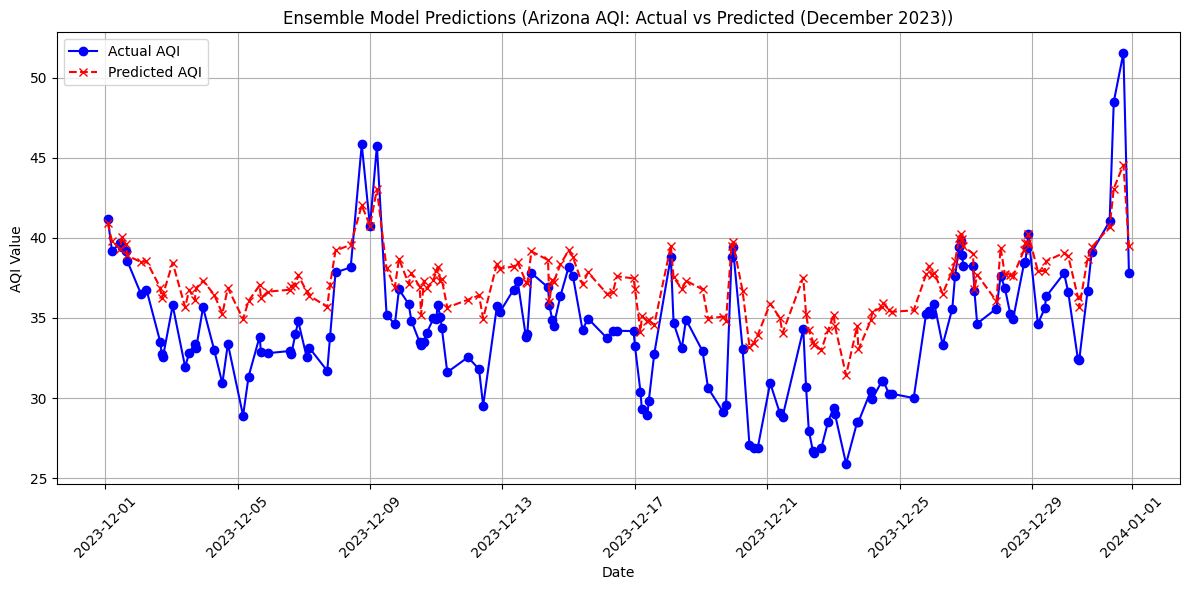

In [3]:
ensemble_predictions['timestamp'] = pd.to_datetime(ensemble_predictions['timestamp'])

# Filter for Arizona and December 2023
filtered_df = ensemble_predictions[
    (ensemble_predictions['state'] == 'Arizona') & 
    (ensemble_predictions['timestamp'].dt.year == 2023) & 
    (ensemble_predictions['timestamp'].dt.month == 12)
]
filtered_df=filtered_df.sort_values(by=['timestamp'],ascending=True)
# Create the visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['timestamp'], filtered_df['actual_aqi'], 'b-', label='Actual AQI', marker='o')
plt.plot(filtered_df['timestamp'], filtered_df['ensemble_predicted_aqi'], 'r--', label='Predicted AQI', marker='x')

plt.title('Ensemble Model Predictions (Arizona AQI: Actual vs Predicted (December 2023))')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('../Plots_And_Metrics/EnsembleModelPredictions(Acutal_Vs_Predicted).png')
# Show the plot
plt.show()

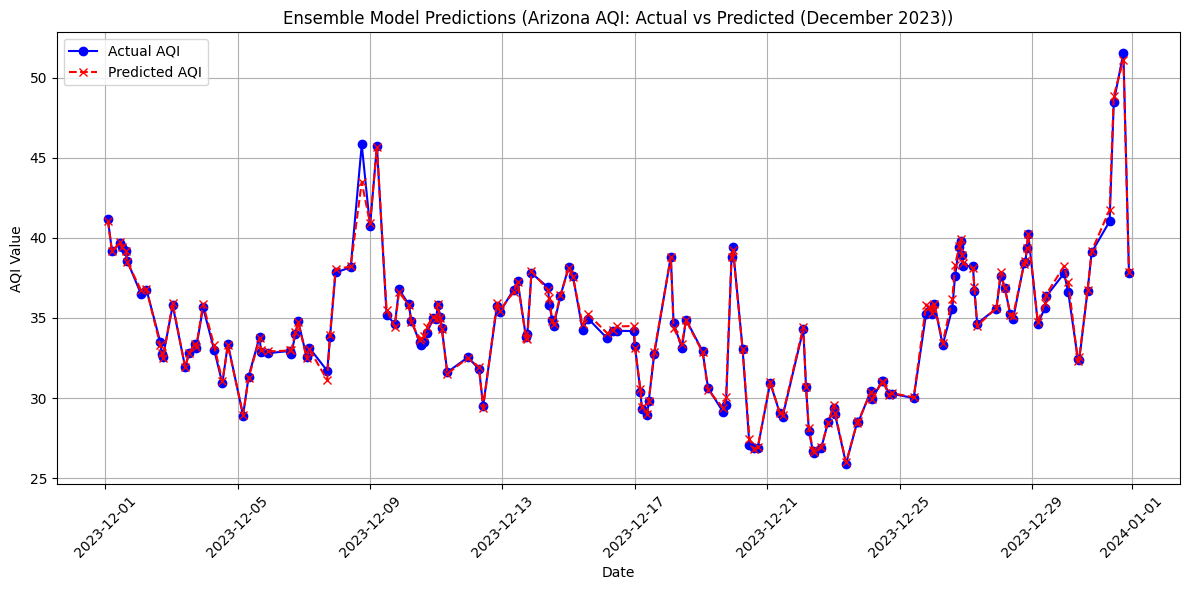

In [4]:
hybrid_predictions['timestamp'] = pd.to_datetime(hybrid_predictions['timestamp'])

# Filter for Arizona and December 2023
filtered_df = hybrid_predictions[
    (hybrid_predictions['state'] == 'Arizona') & 
    (hybrid_predictions['timestamp'].dt.year == 2023) & 
    (hybrid_predictions['timestamp'].dt.month == 12)
]
filtered_df=filtered_df.sort_values(by=['timestamp'],ascending=True)
# Create the visualization
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['timestamp'], filtered_df['actual_aqi'], 'b-', label='Actual AQI', marker='o')
plt.plot(filtered_df['timestamp'], filtered_df['predicted_aqi'], 'r--', label='Predicted AQI', marker='x')

plt.title('Ensemble Model Predictions (Arizona AQI: Actual vs Predicted (December 2023))')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('../Plots_And_Metrics/HybridModelPredictions(Acutal_Vs_Predicted).png')
# Show the plot
plt.show()

# HRAS

In [5]:
def categorize_aqi(value):
    """
    Categorize AQI value based on specified ranges
    """
    if value <= 50:
        return "No Risk"
    elif value <= 100:
        return "Moderate Risk"
    elif value <= 150:
        return "High Risk"
    elif value <= 200:
        return "Severe Risk"
    elif value <= 300:
        return "Very Severe Risk"
    else:
        return "Hazardous"


# Add category columns hybrid
hybrid_predictions['actual_category'] = hybrid_predictions['actual_aqi'].apply(categorize_aqi)
hybrid_predictions['predicted_category'] = hybrid_predictions['predicted_aqi'].apply(categorize_aqi)

#Add category columns ensemble

ensemble_predictions['actual_category'] = ensemble_predictions['actual_aqi'].apply(categorize_aqi)
ensemble_predictions['predicted_category'] = ensemble_predictions['ensemble_predicted_aqi'].apply(categorize_aqi)



In [6]:
def calculate_hras(df):
    """
    Calculate Health Risk Assessment Score (HRAS)
    HRAS = Number of Correctly Predicted Health Risk Levels / Total Predictions
    """
    # Count total number of predictions
    total_predictions = len(df)
    
    # Count correct predictions (where actual_category matches predicted_category)
    correct_predictions = (df['actual_category'] == df['predicted_category']).sum()
    
    # Calculate HRAS
    hras = correct_predictions / total_predictions
    
    # Print detailed results
    print(f"Total Predictions: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"HRAS: {hras:.4f} ({hras*100:.2f}%)")
    
    return hras
ensemble_hras=calculate_hras(ensemble_predictions)
hybrid_hras=calculate_hras(hybrid_predictions)

Total Predictions: 87337
Correct Predictions: 81531
HRAS: 0.9335 (93.35%)
Total Predictions: 87337
Correct Predictions: 87027
HRAS: 0.9965 (99.65%)


## HTPA

In [7]:
import pandas as pd
from datetime import datetime

def calculate_htpa(df, tolerance=5.0):
    """
    Calculate Hourly Time Prediction Accuracy (HTPA) using actual and predicted AQI values
    HTPA = Σ Correct Hourly Predictions / Total Hourly Predictions
    A prediction is considered correct if it's within the tolerance range of the actual value
    """
    # Convert timestamp to datetime if it's string
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract hour from timestamp
    df['hour'] = df['timestamp'].dt.hour
    
    # Define time periods
    def get_time_period(hour):
        if 5 <= hour < 12:
            return 'Morning (5:00-11:59)'
        elif 12 <= hour < 17:
            return 'Afternoon (12:00-16:59)'
        elif 17 <= hour < 22:
            return 'Evening (17:00-21:59)'
        else:
            return 'Night (22:00-4:59)'
    
    df['time_period'] = df['hour'].apply(get_time_period)
    
    # Calculate if prediction is correct (within tolerance range)
    try:
        df['is_correct'] = abs(df['actual_aqi'] - df['ensemble_predicted_aqi']) <= tolerance
    except:
        df['is_correct'] = abs(df['actual_aqi'] - df['predicted_aqi']) <= tolerance
    
    # Calculate HTPA for each hour
    hourly_stats = df.groupby('hour').agg({
        'is_correct': ['count', 'sum', 'mean']
    })
    
    hourly_stats.columns = ['total_predictions', 'correct_predictions', 'accuracy']
    
    # Calculate overall HTPA
    total_correct = df['is_correct'].sum()
    total_predictions = len(df)
    overall_htpa = float(total_correct / total_predictions)
    
    # Calculate time period statistics
    period_stats = df.groupby('time_period').agg({
        'is_correct': ['count', 'sum', 'mean']
    })
    
    period_stats.columns = ['total_predictions', 'correct_predictions', 'accuracy']
    
    # Convert DataFrames to dictionaries with proper formatting
    hourly_stats_dict = {
        str(hour): {
            'total_predictions': int(row['total_predictions']),
            'correct_predictions': int(row['correct_predictions']),
            'accuracy': float(row['accuracy'])
        }
        for hour, row in hourly_stats.iterrows()
    }
    
    period_stats_dict = {
        period: {
            'total_predictions': int(row['total_predictions']),
            'correct_predictions': int(row['correct_predictions']),
            'accuracy': float(row['accuracy'])
        }
        for period, row in period_stats.iterrows()
    }
    
    return {
        'overall_htpa': overall_htpa,
        'hourly_stats': hourly_stats_dict,
        'period_stats': period_stats_dict
    }

# Calculate HTPA for both hybrid and ensemble predictions
hybrid_htpa = calculate_htpa(hybrid_predictions, tolerance=5.0)
ensemble_htpa = calculate_htpa(ensemble_predictions, tolerance=5.0)

# Save results to JSON files
with open('../Plots_And_Metrics/hybrid_htpa.json', 'w') as f:
    json.dump(hybrid_htpa, f, indent=4)

with open('../Plots_And_Metrics/ensemble_htpa.json', 'w') as f:
    json.dump(ensemble_htpa, f, indent=4)
    

In [8]:
hras={'ensemble_hras':ensemble_hras,'hybrid_hras':hybrid_hras}

with open('../Plots_And_Metrics/hras.json','w') as f:
    json.dump(hras,f,indent=4)

# HRAS PLOT

{'ensemble_hras': 0.933521875035781, 'hybrid_hras': 0.9964505307029095}


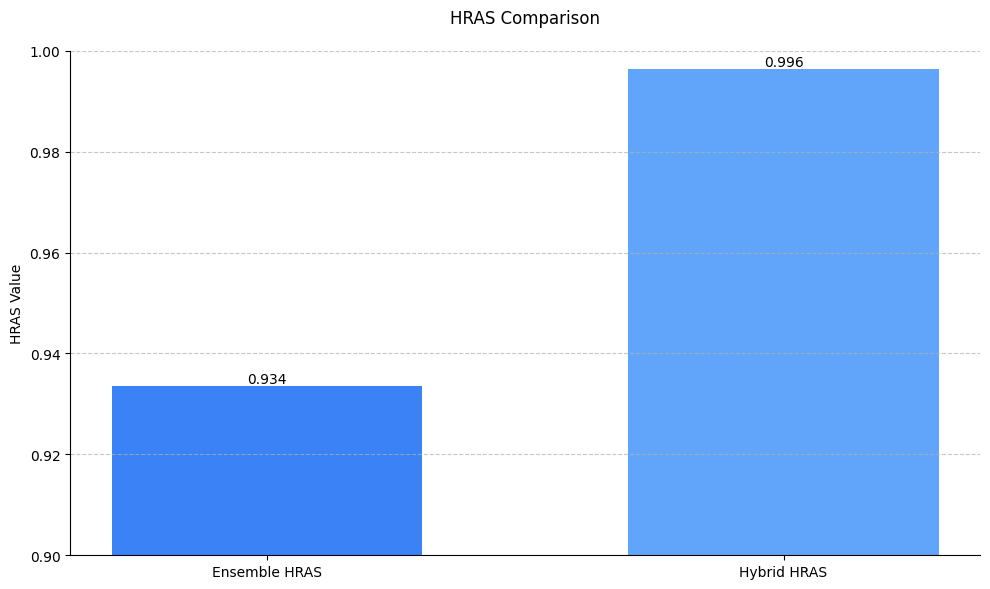

In [15]:
print(hras)
plt.figure(figsize=(10, 6))

# Create bars
bars = plt.bar(
    range(len(hras)), 
    list(hras.values()),
    color=['#3B82F6', '#60A5FA'],  # Blue shades
    width=0.6
)

# Customize the plot
plt.ylim(0.9, 1.0)  # Set y-axis limits to focus on the relevant range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(len(hras)), ['Ensemble HRAS', 'Hybrid HRAS'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom'
    )

# Customize appearance
plt.title('HRAS Comparison', pad=20, fontsize=12)
plt.ylabel('HRAS Value')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('../Plots_And_Metrics/HRAS_Comparison.png')
# Show plot
plt.show()

## HTPA Plot

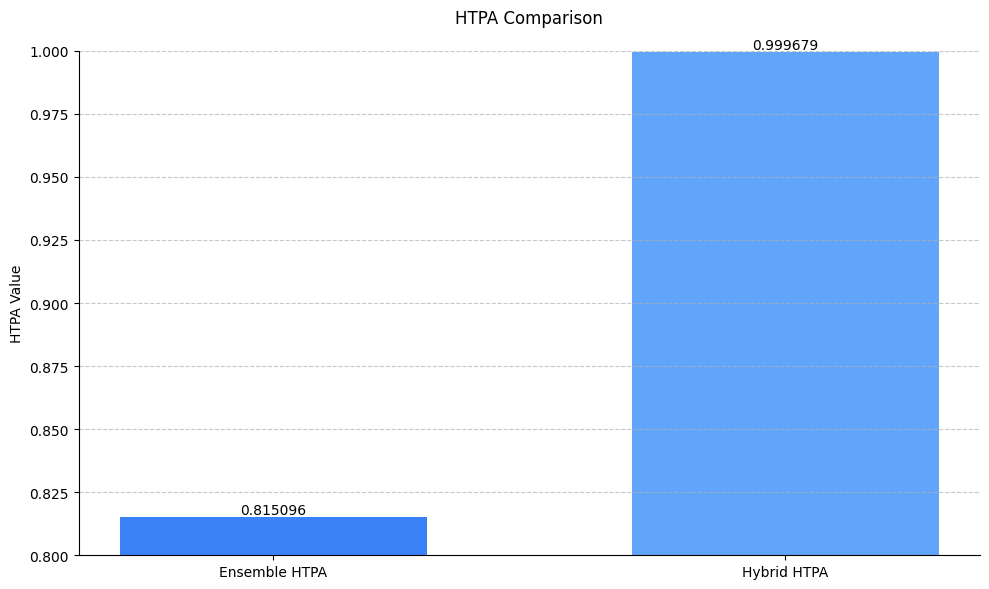

In [17]:
htpa = {
    'Ensemble HTPA': ensemble_htpa['overall_htpa'],
    'Hybrid HTPA': hybrid_htpa['overall_htpa']
}

# Create figure and axis
plt.figure(figsize=(10, 6))

# Create bars
bars = plt.bar(
    range(len(htpa)), 
    list(htpa.values()),
    color=['#3B82F6', '#60A5FA'],  # Blue shades
    width=0.6
)

# Customize the plot
plt.ylim(0.8, 1.0)  # Set y-axis limits to focus on the relevant range
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(len(htpa)), ['Ensemble HTPA', 'Hybrid HTPA'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.6f}',
        ha='center',
        va='bottom'
    )

# Customize appearance
plt.title('HTPA Comparison', pad=20, fontsize=12)
plt.ylabel('HTPA Value')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.savefig('../Plots_And_Metrics/HTPA_Comparison.png')
# Show plot
plt.show()

# Importing other metrics

In [ ]:
with open('../Plots_And_Metrics/hybrid_model_metrics.json','r') as f:
    hybrid_metrics=json.loads(f)

TypeError: the JSON object must be str, bytes or bytearray, not BufferedReader

## R2 score plot